# Identifying Emergency and Disaster Tweets
## Data Source
This project is a Kaggle competition that can be found here: https://www.kaggle.com/competitions/nlp-getting-started/overview.  The competition is part of Kaggle's "Getting Started" series and is designed to be a great way to get started on Natural Language Processing (NLP) tasks.
## Project Overview
The goal of this project is to classify a tweet as to whether or not it is describing emergencies and disasters.  The source data includes a set of 7,614 tweets to be used as training data, and another 3,263 tweets to be used as test data.  The project will follow these high-level tasks:
* Exploratory data analysis including data inspection, visualization, and cleaning
* Model building including model architecture, text vectorization and embedding, and model training
* Collection and analysis of prediction results
* Conclusion and References

## Input data detail
Each data entry includes the following components:
* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (many entries are blank)
* keyword - a particular keyword from the tweet (many entries are blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

# Exploratory Data Analysis
## EDA Commentary 
Inspect, visualize, and clean the data
* The training data has ID, keyword, location, text, and target.  Test data is the same but doesn't have the target.
* Distribution of tweet categories: disaster-oriented tweets are 43%
* Both the training data and test data have duplicates.  These were removed from the training set.
* No empty cells were found in the training or test data
* Each category (disaster-oriented and not disaster-oriented) has an average of 14 to 15 words per tweet


In [1]:
# Load the core libraries to get started
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from tabulate import tabulate  #  See https://pypi.org/project/tabulate/

Training data examples:
╭──────┬───────────┬────────────┬───────────────────────────────────────────────────────────────────┬──────────╮
│   id │   keyword │   location │ text                                                              │   target │
├──────┼───────────┼────────────┼───────────────────────────────────────────────────────────────────┼──────────┤
│    1 │       nan │        nan │ Our Deeds are the Reason of this #earthquake May ALLAH Forgive us │        1 │
│      │           │            │ all                                                               │          │
├──────┼───────────┼────────────┼───────────────────────────────────────────────────────────────────┼──────────┤
│    4 │       nan │        nan │ Forest fire near La Ronge Sask. Canada                            │        1 │
├──────┼───────────┼────────────┼───────────────────────────────────────────────────────────────────┼──────────┤
│    5 │       nan │        nan │ All residents asked to 'shelter in pla

Text(0, 0.5, 'Proportion')

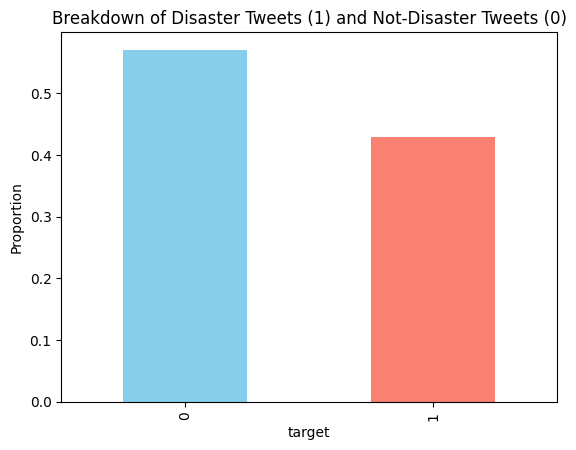

In [2]:
core_path = '/kaggle/input/nlp-getting-started/'
df_train = pd.read_csv(core_path + "train.csv")
df_test = pd.read_csv(core_path + "test.csv")
print("Training data examples:")
print(tabulate(df_train.head(), headers='keys', tablefmt='rounded_grid', 
                                   showindex=False, maxcolwidths=[None, None, None, 65, None]))
print("Test data examples:")
print(tabulate(df_test.head(), headers='keys', tablefmt='rounded_grid', 
                                   showindex=False, maxcolwidths=[None, None, None, 65]))
print("Training data has", len(df_train), "tweets")
print("Number of training data items that are classified as emergency/disaster:", len(df_train[df_train['target'] == 1]))
# Display histogram showing split of disaster / non-disaster tweets
df_train['target'].value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Breakdown of Disaster Tweets (1) and Not-Disaster Tweets (0)')
plt.ylabel('Proportion')

In [3]:
# Check the training data for duplicates
print("Training data has", df_train['text'].nunique(), "unique articles")
print("Training data has", df_train.shape[0] - df_train['text'].nunique(), "duplicate articles")
print("Test data has", df_test['text'].nunique(), "unique articles")
print("Test data has", df_test.shape[0] - df_test['text'].nunique(), "duplicate articles")

Training data has 7503 unique articles
Training data has 110 duplicate articles
Test data has 3243 unique articles
Test data has 20 duplicate articles


In [4]:
# Drop the duplicate news articles in the training data
df_train = df_train.drop_duplicates(subset='text', ignore_index=True)

In [5]:
# Ensure there are no blank message texts in the training or test data
print("Training data messages have a total of", df_train['text'].isna().sum(), "NaNs")
print("Test data messages have a total of", df_test['text'].isna().sum(), "NaNs")
# Ensure there are no blank labels in the training data
print("Training data labels have a total of", df_train['target'].isna().sum(), "NaNs")


Training data messages have a total of 0 NaNs
Test data messages have a total of 0 NaNs
Training data labels have a total of 0 NaNs


       wordCnt                                        
         count  mean  std  min   25%   50%   75%   max
target                                                
0       4305.0  14.7  6.2  1.0  10.0  15.0  19.0  31.0
1       3198.0  15.2  5.2  2.0  11.0  15.0  19.0  54.0
Minimum words in a tweet: 1
Maximum words in a tweet: 54


<Axes: title={'center': 'Average words per tweet per category'}, xlabel='target', ylabel='Average number of words'>

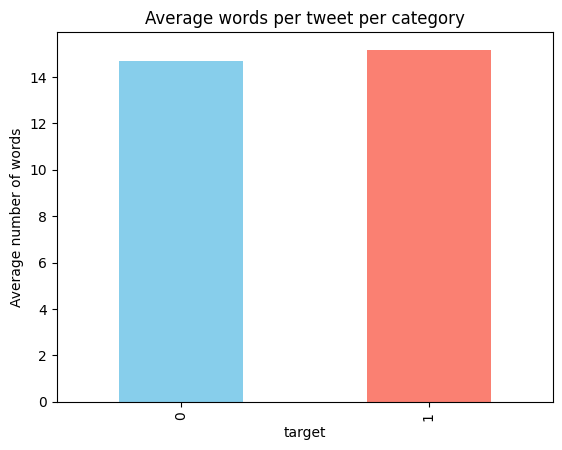

In [6]:
# Calculate number of words per tweet
df_train['wordCnt'] = df_train['text'].str.count(' ') + 1
trainWordsByTarget = df_train[['target', 'wordCnt']].groupby('target').describe()
print(round(trainWordsByTarget, 1))
print("Minimum words in a tweet:", np.min(df_train['wordCnt']))
print("Maximum words in a tweet:", np.max(df_train['wordCnt']))
trainWordsByTarget['wordCnt', 'mean'].plot(kind='bar', ylabel='Average number of words',
                                           color=['skyblue', 'salmon'], 
                                           title='Average words per tweet per category')

## Data Preprocessing
Reference: https://www.tensorflow.org/tutorials/keras/text_classification

Standardization, or data cleaning, refers to preprocessing the text such as removing punctuation or HTML elements to simplify the dataset.  The data cleaning steps here include:
* Make text lowercase
* Remove text in square brackets
* Remove hyperlinks
* Remove punctuation
* Remove words containing numbers
* Remove stopwords 

Stop words are very common words such as "a", "the", "is", and "are".  These are removed from the input data since they won't add meaningful information to the models.

In [7]:
# Reference: https://www.kaggle.com/code/miguelfzzz/natural-language-processing-rnn-lstm-s
# Cleaning the text
import re  # For text cleaning
import string  # For text cleaning

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, 
    remove links, remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [8]:
# Apply the clean_text function from above
df_train['cleaned_text'] = df_train['text'].apply(lambda x:clean_text(x))

In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

def nltk_remove_stopwords(input_text, make_lower = False):
    word_tokens = word_tokenize(input_text)
    if make_lower:
        # converts the words in word_tokens to lower case and then checks whether 
        #they are present in stop_words or not
        filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    else:
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
    final_sentence = ' '.join(filtered_sentence)
    return final_sentence


In [10]:
# Apply the clean_text function from above
df_train['no_stopwords_text'] = df_train['cleaned_text'].apply(lambda x : nltk_remove_stopwords(x))
print(tabulate(df_train.loc[:5,['cleaned_text', 'no_stopwords_text']], 
      headers='keys', tablefmt='rounded_grid', showindex=False, maxcolwidths=[55, 55]))

╭─────────────────────────────────────────────────────────┬─────────────────────────────────────────────────────────╮
│ cleaned_text                                            │ no_stopwords_text                                       │
├─────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────┤
│ our deeds are the reason of this earthquake may allah   │ deeds reason earthquake may allah forgive us            │
│ forgive us all                                          │                                                         │
├─────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────┤
│ forest fire near la ronge sask canada                   │ forest fire near la ronge sask canada                   │
├─────────────────────────────────────────────────────────┼─────────────────────────────────────────────────────────┤
│ all residents asked to shelter in place are being     

In [11]:
# Choose what to use as the source text
#df_train['analysis_text'] = df_train['cleaned_text']
df_train['analysis_text'] = df_train['no_stopwords_text']

## Word Clouds
Here are word cloud visualizations of the disaster tweets and non-disaster tweets

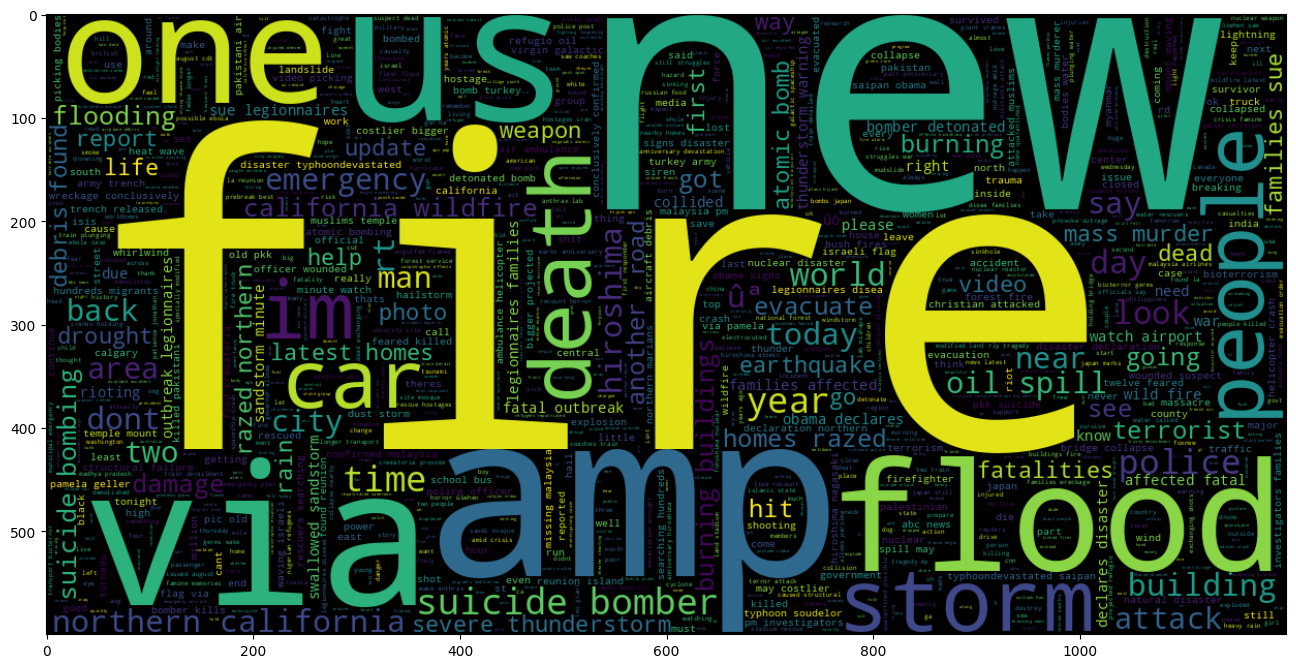

In [12]:
# Create a word cloud of disaster tweets
# Reference: https://www.kaggle.com/code/arunrk7/nlp-beginner-text-classification-using-lstm
from wordcloud import WordCloud

plt.figure(figsize = (16,16)) 
wc = WordCloud(max_words = 1000 , min_word_length=2, width = 1200, height = 600
               ).generate(" ".join(df_train[df_train['target'] == 1].analysis_text))
plt.imshow(wc , interpolation = 'bilinear')

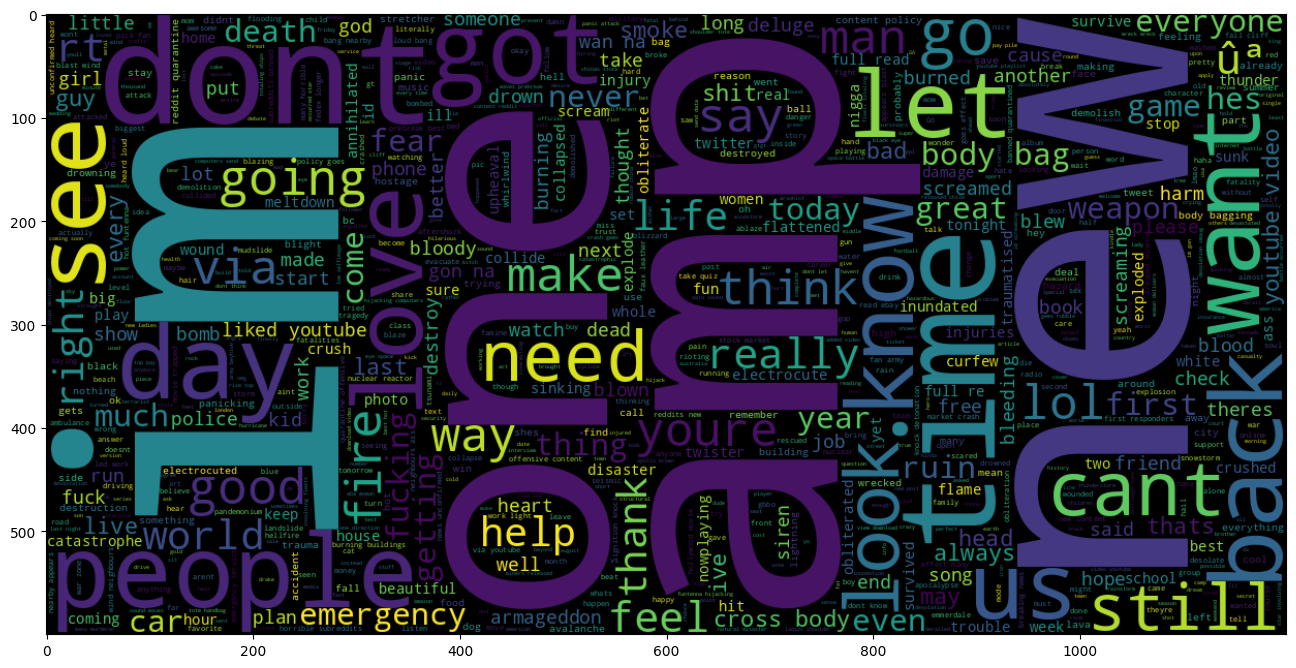

In [13]:
# Create a word cloud of non-disaster tweets
plt.figure(figsize = (16,16)) 
wc = WordCloud(max_words = 1000 , min_word_length=2, width = 1200 , height = 600
              ).generate(" ".join(df_train[df_train['target'] == 0].analysis_text))
plt.imshow(wc , interpolation = 'bilinear')

# Data Preprocessing and Model Building
Data preprocessing includes standardizing (i.e. cleaning), tokenizing (splitting into words or phrases), and vectorizing.  The standardizing process has already been done in the cleaning steps above.

Tokenizing refers to splitting an input text into tokens.  For example, splitting a sentence into individual words by splitting on whitespace. Vectorizing refers to converting tokens into numbers so they can be fed into a neural network.

First, the training data will be split into a training portion and validation portion.

In [14]:
from sklearn.model_selection import train_test_split
X = df_train['analysis_text']  # Result: pandas Series
y = df_train['target']        # Result: pandas Series
y = np.array(y)               # Result: numpy array
validation_portion = 0.2
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=validation_portion,
                                                                shuffle=True, random_state=1243)
# Result: X_train, X_validation are pandas Series of text.  y_train, y_validation are numpy arrays of 0's and 1's

trainWords = 0
for item in X_train: trainWords += len(re.findall(r'\w+', item))
print(f"The training portion has {len(X_train)} tweets with a total of {trainWords} words")
valWords = 0
for item in X_validation: valWords += len(re.findall(r'\w+', item))
print(f"The validation portion has {len(X_validation)} tweets with a total of {valWords} words")

The training portion has 6002 tweets with a total of 54139 words
The validation portion has 1501 tweets with a total of 13361 words


In the following, the input data is tokenized and encoded using one_hot and then the resulting vectors are padded so that they are all the same length.

In [15]:
# Reference: https://www.kaggle.com/code/varadkelkar02/disaster-tweet-classification-nlp
def create_onehot_embedded_sequence(text, vocab_size, maxWords = 0):
    onehot_vec = [one_hot(tweet, vocab_size) for tweet in text]  
    # onehot_vec_train: list of lists of len 6002 (same as len text).  Each sub-list has varying 
    #                   length matching the corresponding tweet.  Each sub-list is a list of word indices.

    tweet_lengths = []
    for i in onehot_vec:
        tweet_lengths.append(len(i))

    if maxWords == 0:
        maxWords = np.max(tweet_lengths)
    print(f'Word length: Max: {maxWords}, Min: {min(tweet_lengths)}')

    # Pad the sequences with 0's at the end so that they are all the same length
    embedded_docs = pad_sequences(onehot_vec, padding='post', maxlen=maxWords)
    return embedded_docs

In [16]:
# Reference: https://spotintelligence.com/2023/01/11/lstm-in-nlp-tasks/#How_to_implement_an_LSTM_in_NLP_for_text_classification
# Alternative for tokenize, vectorize, and pad
def alt_preprocessing(text, vocab_size, max_len = 100):
    # Tokenize the texts and create a vocabulary
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    # Pad the sequences so they all have the same length
    x = pad_sequences(sequences, maxlen=max_len)
    return x

## Model Architectures
Several model architectures are included below including a simple RNN network and several LSTM networks.  A GRU network is also defined but wasn't used in the model fitting process that follows due to it not quite matching the execution flow of the others.  The LSTM models have increasing complexity finishing with the "Multi-layer LSTM" which has a stack of 4 LSTMs.  In the end, this stacked LSTM model had the best performance.
* Model #1:  Super simple RNN
* Model #2:  Super simple LSTM
* Model #3:  Somewhat simple LSTM but has max pooling, batch normalization, and dropout
* Model #4:  A bidirectional version of Model #3
* Model #5:  A stack of 4 LSTMs
* Model #6:  A Gated Recurrent Network (GRU)
Note that Model 4 had problems running and was abandoned.  Model 6 didn't fit the pipeline easily and was abandoned.

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, BatchNormalization, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
print("Tensorflow version:", tf.__version__)

2024-04-05 18:39:15.385015: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 18:39:15.385102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 18:39:15.386694: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version: 2.15.0


In [18]:
def simple_RNN_model(vocab_size, embedding_out_size, maxWords):
    model = Sequential()
    model.add(Input(shape=(maxWords,)))  # maxWords is the padding length
    # For Embedding layer: input_dim is size of vocab, output_dim is length of the vector for each word
    # Deprecated input_length is max length of a sequence (this is included in a million examples, but not supported by the code)
    # The embedding layer is then an array of dimension input_dim x output_dim and initialized with random values
    model.add(Embedding(input_dim = vocab_size, output_dim = embedding_out_size))
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [19]:
def simple_LSTM_model(vocab_size, embedding_out_size, maxWords):
    lstm_model = Sequential()
    #lstm_model.add(Input(shape=(SENTENCE_LENGTH,)))
    lstm_model.add(Input(shape=(maxWords,)))  # maxWords is the padding length
    # For Embedding layer: input_dim is size of vocab, output_dim is length of the vector for each word
    # Deprecated input_length is max length of a sequence (this is included in a million examples, but not supported by the code)
    # The embedding layer is then an array of dimension input_dim x output_dim and initialized with random values
    lstm_model.add(Embedding(input_dim = vocab_size, output_dim = embedding_out_size))
    lstm_model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    lstm_model.add(Dense(1, activation='sigmoid'))
    return lstm_model

In [20]:
def basic_LSTM_model(vocab_size, embedding_out_size, maxWords):
    lstm_model = Sequential()
    #lstm_model.add(Input(shape=(SENTENCE_LENGTH,)))
    lstm_model.add(Input(shape=(maxWords,)))  # maxWords is the padding length
    # For Embedding layer: input_dim is size of vocab, output_dim is length of the vector for each word
    # Deprecated input_length is max length of a sequence (this is included in a million examples, but not supported by the code)
    # The embedding layer is then an array of dimension input_dim x output_dim and initialized with random values
    lstm_model.add(Embedding(input_dim = vocab_size, output_dim = embedding_out_size))
    lstm_model.add(LSTM(units=100, return_sequences=True))
    lstm_model.add(GlobalMaxPool1D())
    lstm_model.add(BatchNormalization())
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(10, activation='relu'))
    lstm_model.add(Dropout(0.25))
    lstm_model.add(Dense(1, activation='sigmoid'))
    return lstm_model

In [21]:
def biDir_LSTM_model(vocab_size, embedding_out_size, maxWords):
    lstm_model = Sequential()
    #lstm_model.add(Input(shape=(SENTENCE_LENGTH,)))
    lstm_model.add(Input(shape=(maxWords,)))  # maxWords is the padding length
    # For Embedding layer: input_dim is size of vocab, output_dim is length of the vector for each word
    # Deprecated input_length is max length of a sequence (this is included in a million examples, but not supported by the code)
    # The embedding layer is then an array of dimension input_dim x output_dim and initialized with random values
    lstm_model.add(Embedding(input_dim = vocab_size, output_dim = embedding_out_size))
    lstm_model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
    lstm_model.add(GlobalMaxPool1D())
    lstm_model.add(BatchNormalization())
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(10, activation='relu'))
    lstm_model.add(Dropout(0.25))
    lstm_model.add(Dense(1, activation='sigmoid'))
    return lstm_model

In [22]:
def Multi_LSTM_model(vocab_size, embedding_out_size, maxWords):
    model = Sequential()
    model.add(Input(shape=(maxWords,)))  # maxWords is the padding length
    # For Embedding layer: input_dim is size of vocab, output_dim is length of the vector for each word
    # Deprecated input_length is max length of a sequence (this is included in a million examples, but not supported by the code)
    # The embedding layer is then an array of dimension input_dim x output_dim and initialized with random values
    model.add(Embedding(input_dim = vocab_size, output_dim = embedding_out_size))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [23]:
# From https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru
def GRU_model(vocab_size, embedding_out_size, maxWords):
    model = Sequential()
    model.add(Input(shape=(maxWords,)))  # maxWords is the padding length
    # For Embedding layer: input_dim is size of vocab, output_dim is length of the vector for each word
    # Deprecated input_length is max length of a sequence (this is included in a million examples, but not supported by the code)
    # The embedding layer is then an array of dimension input_dim x output_dim and initialized with random values
    model.add(Embedding(input_dim = vocab_size, output_dim = embedding_out_size))
    # First GRU layer with Dropout regularisation
    model.add(GRU(units=50, return_sequences=True, input_shape=(maxWords,), activation='tanh'))
    model.add(Dropout(0.2))
    # Second GRU layer
    model.add(GRU(units=50, return_sequences=True, input_shape=(maxWords,), activation='tanh'))
    model.add(Dropout(0.2))
    # Third GRU layer
    model.add(GRU(units=50, return_sequences=True, input_shape=(maxWords,), activation='tanh'))
    model.add(Dropout(0.2))
    # Fourth GRU layer
    model.add(GRU(units=50, activation='tanh'))
    model.add(Dropout(0.2))
    # The output layer
    model.add(Dense(units=1))
    # Compiling the RNN
    #model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    #regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)
    return model

## Model Building and Fitting
Compiling: All of the models were compiled using the Adam optimizer and binary cross-entropy for the loss.

Fitting: All of the models were fit using Early Stopping and Model Checkpoint in order to get back to the best set of weights.

In [24]:
def build_model(model_builder, vocab_size, embedding_out_size, maxWords, LR):
    model = model_builder(vocab_size, embedding_out_size, maxWords)
    model.compile(loss='binary_crossentropy', 
                        optimizer = tf.keras.optimizers.Adam(learning_rate = LR),
                        metrics=['accuracy'])
    model.summary()
    return model

In [25]:
checkpoint_filepath = '/kaggle/working/checkpoint.model.keras'

def run_model(model, embedded_X, y_train, val_split=0.2, numEpochs=20, do_early_stopping = False, 
              patience=10, scheduleLR = False):
    callback_lst = []
    if do_early_stopping:
        # Stop the fitting process early if the validation loss stops decreasing after 3 epochs
        early_stopping = EarlyStopping(monitor="val_loss", patience=patience, 
                                       restore_best_weights = True, verbose=1)
        callback_lst.append(early_stopping)
        
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, 
                                                monitor='val_loss', mode='min', save_best_only=True)
    callback_lst.append(model_checkpoint_callback)

    if scheduleLR == True:
        ReduceLROnPlateau_clbk = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.05, patience=2,
                                                   mode = 'min', min_lr = 0.000001, verbose = 1)    
        callback_lst.append(ReduceLROnPlateau_clbk)
    #    history = model.fit(train_gen, validation_data=validation_gen,
    #                            epochs=numEpochs, callbacks=[early_stopping]).history
    #history = lstm_model.fit(embedded_docs_train, y_train, epochs = numEpochs, batch_size = 32, callbacks=[early_stopping])
    history = model.fit(x=embedded_X, y=y_train, validation_split=val_split,
                             epochs = numEpochs, batch_size = 32, callbacks=callback_lst)
    return history

In [26]:
# Determine which epoch had the best performance based on the validation loss metric
# Once determined, return the epoch number, validation loss, validation accuracy, and val AUC
# The input history is from a model fitting process
def get_best_metrics(history):
    # Fit history keys ['accuracy', 'loss', 'val_accuracy', 'val_loss'])
    minIndex = np.argmin(history["val_loss"])
    best_epoch = minIndex + 1
    best_loss = history['val_loss'][minIndex]
    best_accuracy = history['val_accuracy'][minIndex]
    return best_epoch, best_loss, best_accuracy

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(y_test, y_pred_label):
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred_label), annot=True, fmt='.0f')
    plt.title("Confusion Matrix on Validation Data")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()
    
    #disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_label))
    #disp.plot()

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
def predict_and_score(model, embedded_val, y_val):
    y_pred = (model.predict(embedded_val) > 0.5).astype("int32")
    print(f'Accuracy: {accuracy_score(y_val, y_pred):.4f}')
    print(f'F1 score: {f1_score(y_val, y_pred):.4f}')
    plot_confusion_matrix(y_val, y_pred)

In [44]:
# Prepare the text of the test set
df_test['cleaned_text'] = df_test['text'].apply(lambda x:clean_text(x))
df_test['no_stopwords_text'] = df_test['cleaned_text'].apply(lambda x : nltk_remove_stopwords(x))
df_test['analysis_text'] = df_test['no_stopwords_text']
X_test = df_test['analysis_text']

In [45]:
MAX_WORDS = 32
def evaluate_model(model_builder, vocab_size, embed_out_size, learning_rate, resultsIdx, maxWords=MAX_WORDS):
    embed_train = create_onehot_embedded_sequence(X_train, vocab_size, maxWords=maxWords)
    embed_val = create_onehot_embedded_sequence(X_validation, vocab_size, maxWords=maxWords)
    model = build_model(model_builder, vocab_size, embed_out_size, maxWords, LR=learning_rate)
    history = run_model(model, embed_train, y_train, numEpochs = 50, 
                        do_early_stopping = True, patience=4, scheduleLR = False)
    bestModel = tf.keras.models.load_model(checkpoint_filepath)
    predict_and_score(bestModel, embed_val, y_validation)
    
    #print(history.history.keys())
    modelMetrics = get_best_metrics(history.history)
    print(f"Best Epoch: {modelMetrics[0]}")
    print(f"Best Model Validation Loss: {round(modelMetrics[1], 4)}")
    print(f"Best Model Validation Accuracy: {round(modelMetrics[2], 4)}")
    model_results.at[resultsIdx, 'Val loss'] = modelMetrics[1]
    model_results.at[resultsIdx, 'Val accuracy'] = modelMetrics[2]
    return bestModel, history

In [46]:
def generate_output_csv_file(model, embed_test, filename):
    y_pred = (model.predict(embed_test) > 0.5).astype("int32")
    print("type ", type(y_pred))
    #out_df = pd.DataFrame({"id": df_test['id'].values.tolist(), "target": y_pred})
    out_df = pd.DataFrame({"id": df_test['id'].values.tolist()})
    out_df['target'] = y_pred
    out_df.to_csv(os.path.join("/kaggle/working/", filename), index=False)    

In [47]:
def run_and_record_model(modelName, model, embed_test, vocab_size, embed_out_size, 
                         LR, resultsIdx, filename):
    print(f"\nEvaluate {modelName} model --------------------------------------------------------")
    model_results.at[resultsIdx, 'Model'] = modelName
    model_results.at[resultsIdx, 'Vocab size'] = vocab_size
    model_results.at[resultsIdx, 'Output vector size'] = embed_out_size
    model_results.at[resultsIdx, 'Learning rate'] = LR
    bestModel, history = evaluate_model(model, vocab_size, embed_out_size, LR, resultsIdx)
    # fitting_histories[resultsIdx] = history
    generate_output_csv_file(bestModel, embed_test, filename)

Word length: Max: 32, Min: 0

Evaluate Simple RNN model --------------------------------------------------------
Word length: Max: 32, Min: 0
Word length: Max: 32, Min: 1


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 32, 15)         │       300,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,701 (1.19 MB)

 Trainable params: 311,701 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5162 - loss: 0.6915 - val_accuracy: 0.5637 - val_loss: 0.6801
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5948 - loss: 0.6703 - val_accuracy: 0.5987 - val_loss: 0.6624
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6593 - loss: 0.6251 - val_accuracy: 0.6761 - val_loss: 0.6111
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7566 - loss: 0.5096 - val_accuracy: 0.7044 - val_loss: 0.5820
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8226 - loss: 0.4356 - val_accuracy: 0.7294 - val_loss: 0.5756
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8527 - loss: 0.3688 - val_accuracy: 0.7261 - val_loss: 0.5812
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8800 - loss: 0.3227 - val_accuracy: 0.7286 - val_loss: 0.6098
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9090 - loss: 0.2710 - val_accu

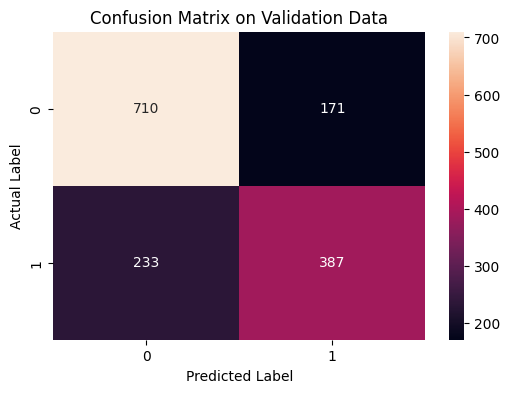

Best Epoch: 5
Best Model Validation Loss: 0.5756
Best Model Validation Accuracy: 0.7294
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
type  <class 'numpy.ndarray'>

Evaluate Simple LSTM model --------------------------------------------------------
Word length: Max: 32, Min: 0
Word length: Max: 32, Min: 1


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 32, 15)         │       300,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 100)            │        46,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,501 (1.32 MB)

 Trainable params: 346,501 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5617 - loss: 0.6909 - val_accuracy: 0.5729 - val_loss: 0.6859
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5651 - loss: 0.6868 - val_accuracy: 0.5729 - val_loss: 0.6826
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5754 - loss: 0.6821 - val_accuracy: 0.5729 - val_loss: 0.6820
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5787 - loss: 0.6804 - val_accuracy: 0.5729 - val_loss: 0.6820
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5681 - loss: 0.6836 - val_accuracy: 0.5729 - val_loss: 0.6819
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5717 - loss: 0.6816 - val_accuracy: 0.5729 - val_loss: 0.6814
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5740 - loss: 0.6813 - val_accuracy: 0.5729 - val_loss: 0.6808
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5555 - loss: 0.6832 - val_accu

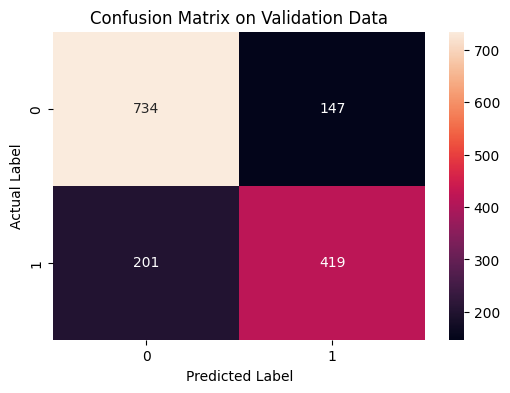

Best Epoch: 11
Best Model Validation Loss: 0.5114
Best Model Validation Accuracy: 0.7685
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
type  <class 'numpy.ndarray'>

Evaluate Multi LSTM model --------------------------------------------------------
Word length: Max: 32, Min: 0
Word length: Max: 32, Min: 1


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 32, 15)         │       300,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 32, 50)         │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 32, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 32, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,851 (1.43 MB)

 Trainable params: 373,851 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.5563 - loss: 0.6901 - val_accuracy: 0.5729 - val_loss: 0.6816
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.5737 - loss: 0.6808 - val_accuracy: 0.5729 - val_loss: 0.6800
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5664 - loss: 0.6803 - val_accuracy: 0.5729 - val_loss: 0.6761
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.5769 - loss: 0.6665 - val_accuracy: 0.7369 - val_loss: 0.5766
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.8077 - loss: 0.4734 - val_accuracy: 0.7818 - val_loss: 0.5181
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.8549 - loss: 0.3583 - val_accuracy: 0.7660 - val_loss: 0.5258
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8836 - loss: 0.3065 - val_accuracy: 0.7560 - val_loss: 0.5588
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9057 - loss: 0.2679 - va

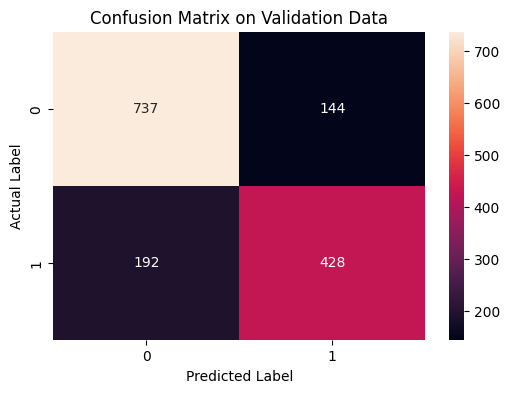

Best Epoch: 5
Best Model Validation Loss: 0.5181
Best Model Validation Accuracy: 0.7818
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
type  <class 'numpy.ndarray'>

Evaluate Multi LSTM model --------------------------------------------------------
Word length: Max: 32, Min: 0
Word length: Max: 32, Min: 1


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 32, 150)        │     7,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 32, 50)         │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 32, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 32, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,600,851 (28.99 MB)

 Trainable params: 7,600,851 (28.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.5806 - loss: 0.6874 - val_accuracy: 0.5729 - val_loss: 0.6809
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.5659 - loss: 0.6819 - val_accuracy: 0.5729 - val_loss: 0.6747
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.6022 - loss: 0.6464 - val_accuracy: 0.7877 - val_loss: 0.4925
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.8696 - loss: 0.3595 - val_accuracy: 0.7893 - val_loss: 0.4896
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.9080 - loss: 0.2607 - val_accuracy: 0.7752 - val_loss: 0.5431
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.9351 - loss: 0.2059 - val_accuracy: 0.7877 - val_loss: 0.5734
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.9537 - loss: 0.1607 - val_accuracy: 0.7794 - val_loss: 0.6334
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.9675 - loss: 0.1166 -

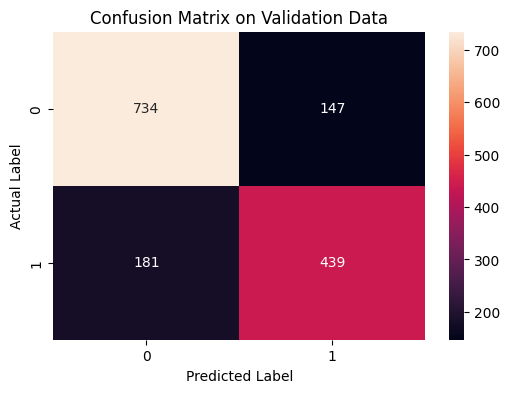

Best Epoch: 4
Best Model Validation Loss: 0.4896
Best Model Validation Accuracy: 0.7893
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
type  <class 'numpy.ndarray'>

Evaluate Multi LSTM model --------------------------------------------------------
Word length: Max: 32, Min: 0
Word length: Max: 32, Min: 1


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 32, 150)        │       750,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 32, 50)         │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 32, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 32, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 850,851 (3.25 MB)

 Trainable params: 850,851 (3.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.5583 - loss: 0.6888 - val_accuracy: 0.5729 - val_loss: 0.6802
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.5687 - loss: 0.6806 - val_accuracy: 0.5729 - val_loss: 0.6748
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.5892 - loss: 0.6588 - val_accuracy: 0.7694 - val_loss: 0.5285
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.8421 - loss: 0.4088 - val_accuracy: 0.7727 - val_loss: 0.4993
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.8782 - loss: 0.3311 - val_accuracy: 0.7677 - val_loss: 0.5318
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9037 - loss: 0.2799 - val_accuracy: 0.7652 - val_loss: 0.5497
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9214 - loss: 0.2461 - val_accuracy: 0.7552 - val_loss: 0.6246
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9306 - loss: 0.2213 - 

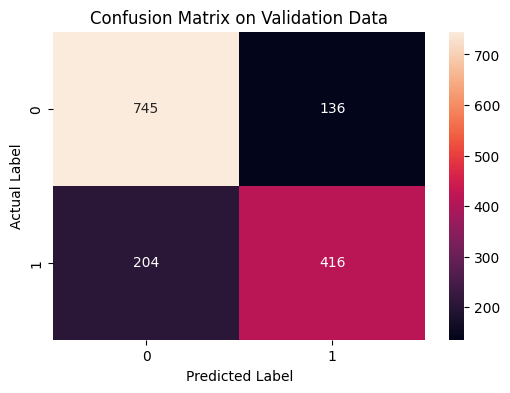

Best Epoch: 4
Best Model Validation Loss: 0.4993
Best Model Validation Accuracy: 0.7727
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
type  <class 'numpy.ndarray'>

Evaluate Multi LSTM model --------------------------------------------------------
Word length: Max: 32, Min: 0
Word length: Max: 32, Min: 1


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 32, 15)         │       300,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 32, 50)         │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 32, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 32, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,851 (1.43 MB)

 Trainable params: 373,851 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.5609 - loss: 0.6910 - val_accuracy: 0.5729 - val_loss: 0.6827
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5771 - loss: 0.6809 - val_accuracy: 0.5729 - val_loss: 0.6807
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.5605 - loss: 0.6841 - val_accuracy: 0.5729 - val_loss: 0.6761
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5822 - loss: 0.6576 - val_accuracy: 0.7469 - val_loss: 0.5531
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8300 - loss: 0.4177 - val_accuracy: 0.7635 - val_loss: 0.5206
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.8645 - loss: 0.3538 - val_accuracy: 0.7577 - val_loss: 0.5448
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8834 - loss: 0.2977 - val_accuracy: 0.7644 - val_loss: 0.5534
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9033 - loss: 0.2749 - 

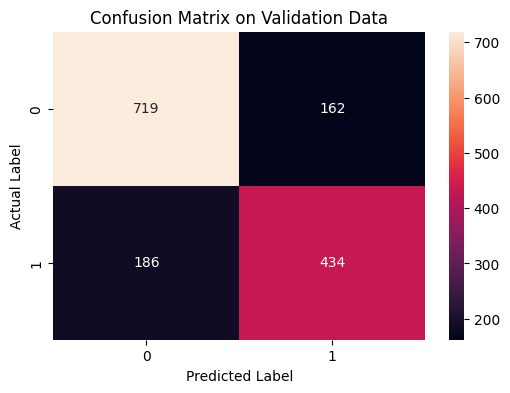

Best Epoch: 5
Best Model Validation Loss: 0.5206
Best Model Validation Accuracy: 0.7635
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
type  <class 'numpy.ndarray'>

Evaluate Multi LSTM model --------------------------------------------------------
Word length: Max: 32, Min: 0
Word length: Max: 32, Min: 1


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 32, 15)         │       300,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 32, 50)         │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 32, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 32, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,851 (1.43 MB)

 Trainable params: 373,851 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.5533 - loss: 0.6928 - val_accuracy: 0.5729 - val_loss: 0.6915
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.5720 - loss: 0.6911 - val_accuracy: 0.5729 - val_loss: 0.6894
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.5799 - loss: 0.6882 - val_accuracy: 0.5729 - val_loss: 0.6861
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.5649 - loss: 0.6864 - val_accuracy: 0.5729 - val_loss: 0.6830
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.5587 - loss: 0.6854 - val_accuracy: 0.5729 - val_loss: 0.6816
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5599 - loss: 0.6844 - val_accuracy: 0.5729 - val_loss: 0.6809
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.5671 - loss: 0.6824 - val_accuracy: 0.5729 - val_loss: 0.6805
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.5656 - loss: 0.6817 - v

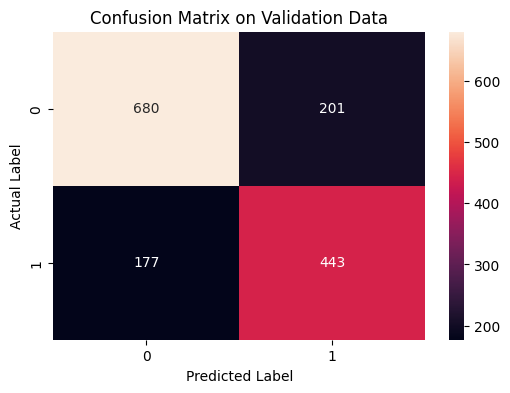

Best Epoch: 21
Best Model Validation Loss: 0.5566
Best Model Validation Accuracy: 0.7361
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
type  <class 'numpy.ndarray'>

Evaluate Multi LSTM model --------------------------------------------------------
Word length: Max: 32, Min: 0
Word length: Max: 32, Min: 1


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 32, 150)        │     7,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 32, 50)         │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 32, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 32, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 32, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,600,851 (28.99 MB)

 Trainable params: 7,600,851 (28.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.5618 - loss: 0.6920 - val_accuracy: 0.5729 - val_loss: 0.6892
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.5637 - loss: 0.6891 - val_accuracy: 0.5729 - val_loss: 0.6858
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.5805 - loss: 0.6835 - val_accuracy: 0.5729 - val_loss: 0.6826
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.5775 - loss: 0.6802 - val_accuracy: 0.5729 - val_loss: 0.6811
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.5662 - loss: 0.6822 - val_accuracy: 0.5729 - val_loss: 0.6806
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.5627 - loss: 0.6822 - val_accuracy: 0.5729 - val_loss: 0.6800
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.5717 - loss: 0.6788 - val_accuracy: 0.5729 - val_loss: 0.6793
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.5680 - loss: 0.6791 - 

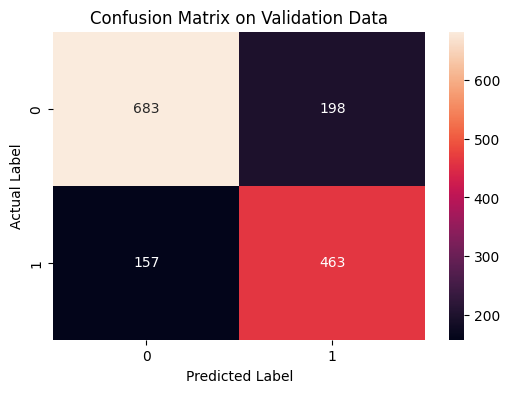

Best Epoch: 15
Best Model Validation Loss: 0.5259
Best Model Validation Accuracy: 0.7868
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
type  <class 'numpy.ndarray'>


In [48]:
# Now, run the three model architectures through a series of runs using different values for the
#   vocabulary size, embedding layer output vector size, max sequence length, and learning rate 
# Data frame to collect the results
model_results = pd.DataFrame(columns = ['Model', 'Vocab size', 'Output vector size', 'Learning rate',
                                        'Val accuracy', 'Val loss', 'Test score'])
fitting_histories = np.zeros(10)

# Run the simple RNN, simple LSTM, and multi-layer LSTM models with a vocab size of 20k, output vector
#   size of 15, max sequence length of 32, and a learning rate of 0.00005
vocab_size, embed_out_size, maxWords, LR = 20000, 15, 32, 0.00005
embed_test = create_onehot_embedded_sequence(X_test, vocab_size, maxWords=maxWords)
resultsIdx = 0
run_and_record_model("Simple RNN"+str(resultsIdx), simple_RNN_model, embed_test, vocab_size, 
                     embed_out_size, LR, resultsIdx, 
                     "simpleRNN_Model_TestPreds" + str(resultsIdx) + ".csv")

resultsIdx += 1
run_and_record_model("Simple LSTM"+ str(resultsIdx), simple_LSTM_model, embed_test, vocab_size,
                     embed_out_size, LR, resultsIdx, 
                     "simpleLSTM_Model_TestPreds" + str(resultsIdx) + ".csv")

resultsIdx += 1
run_and_record_model("Multi LSTM"+ str(resultsIdx), Multi_LSTM_model, embed_test, vocab_size, 
                     embed_out_size, LR, resultsIdx, 
                     "multiLSTM_Model_TestPreds" + str(resultsIdx) + ".csv")

# Adjust the parameters and run just the multi-layer LSTM since it did the best above.
vocab_size, embed_out_size, maxWords, LR = 50000, 150, 32, 0.00005
resultsIdx += 1
run_and_record_model("Multi LSTM"+ str(resultsIdx), Multi_LSTM_model, embed_test, vocab_size, 
                     embed_out_size, LR, resultsIdx, 
                     "multiLSTM_Model_TestPreds" + str(resultsIdx) + ".csv")

vocab_size, embed_out_size, maxWords, LR = 5000, 150, 32, 0.00005
resultsIdx += 1
run_and_record_model("Multi LSTM"+ str(resultsIdx), Multi_LSTM_model, embed_test, vocab_size, 
                     embed_out_size, LR, resultsIdx, 
                     "multiLSTM_Model_TestPreds" + str(resultsIdx) + ".csv")

vocab_size, embed_out_size, maxWords, LR = 20000, 15, 20, 0.00005
resultsIdx += 1
run_and_record_model("Multi LSTM"+ str(resultsIdx), Multi_LSTM_model, embed_test, vocab_size, 
                     embed_out_size, LR, resultsIdx, 
                     "multiLSTM_Model_TestPreds" + str(resultsIdx) + ".csv")

vocab_size, embed_out_size, maxWords, LR = 20000, 15, 32, 0.00001
resultsIdx += 1
run_and_record_model("Multi LSTM"+ str(resultsIdx), Multi_LSTM_model, embed_test, vocab_size, 
                     embed_out_size, LR, resultsIdx, 
                     "multiLSTM_Model_TestPreds" + str(resultsIdx) + ".csv")

vocab_size, embed_out_size, maxWords, LR = 50000, 150, 32, 0.00001
resultsIdx += 1
run_and_record_model("Multi LSTM"+ str(resultsIdx), Multi_LSTM_model, embed_test, vocab_size, 
                     embed_out_size, LR, resultsIdx, 
                     "multiLSTM_Model_TestPreds" + str(resultsIdx) + ".csv")

# Results and Analysis
The following table provides a listing of the performance for each model including the validation loss, validation accuracy, and for three models, the test score against the test data.  None of the models were able to break above 80% for validation accuracy.

In addition to the table below, the confusion matrices above show that all of the models did pretty well correctly identifying non-emergency/disaster tweets with around 88% correct.  However, they didn't do as well identifying emergency/disaster tweets, with performance around 75%.

## Hyper-parameter tuning
The vocabulary size, output vector size, and learning rate were all varied.  However, no significant impact on performance was seen.  Instead, the model architecture had more impact.

In [51]:
print(tabulate(model_results, headers='keys', tablefmt='rounded_grid', showindex=False))

╭─────────────┬──────────────┬──────────────────────┬─────────────────┬────────────────┬────────────┬──────────────╮
│ Model       │   Vocab size │   Output vector size │   Learning rate │   Val accuracy │   Val loss │   Test score │
├─────────────┼──────────────┼──────────────────────┼─────────────────┼────────────────┼────────────┼──────────────┤
│ Simple RNN  │        20000 │                   15 │           5e-05 │       0.729392 │   0.575639 │      nan     │
├─────────────┼──────────────┼──────────────────────┼─────────────────┼────────────────┼────────────┼──────────────┤
│ Simple LSTM │        20000 │                   15 │           5e-05 │       0.768526 │   0.511414 │      nan     │
├─────────────┼──────────────┼──────────────────────┼─────────────────┼────────────────┼────────────┼──────────────┤
│ Multi LSTM  │        20000 │                   15 │           5e-05 │       0.781848 │   0.51809  │        0.741 │
├─────────────┼──────────────┼──────────────────────┼───────────

# Conclusion
There are many variables in text classification including how the text is cleaned, vectorized, and embedded as well as the many model architectures including RNN and LSTM.  With more time and tuning, a performance above 80% can certainly be reached.

Varying the learning rate did not help as much as I thought it would.  I did try to use Learning Rate Scheduling but couldn't get it tuned correctly and the Early Stopping always kicked in before the LR Scheduling made adjustments.